# Import

In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from setup_problem import load_problem
import pickle
from sklearn.metrics import confusion_matrix

In [3]:
class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True,figsize = (12,8))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].xaxis.label.set_color('w')
        axs[i].tick_params(axis='x', colors='w')
        axs[i].yaxis.label.set_color('w')
        axs[i].tick_params(axis='y', colors='w')
        axs[i].set_title(title, color = 'w')

    fig.subplots_adjust(hspace=0.3)
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions", color = 'w')
    ax.xaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='y', colors='w')
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

# Clean

In [4]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem("lasso_data.pickle")
X_train = featurize(x_train)
X_val = featurize(x_val)

In [5]:
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)

# 2.1

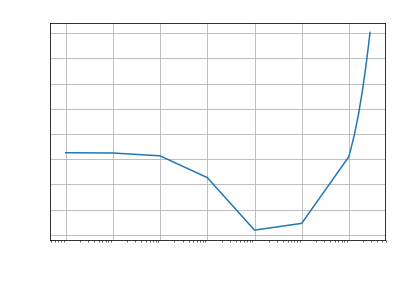

In [6]:
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.grid()
ax.set_title("Validation Performance vs Regularization",color = 'w')
ax.set_xlabel("Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

# 2.2 

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


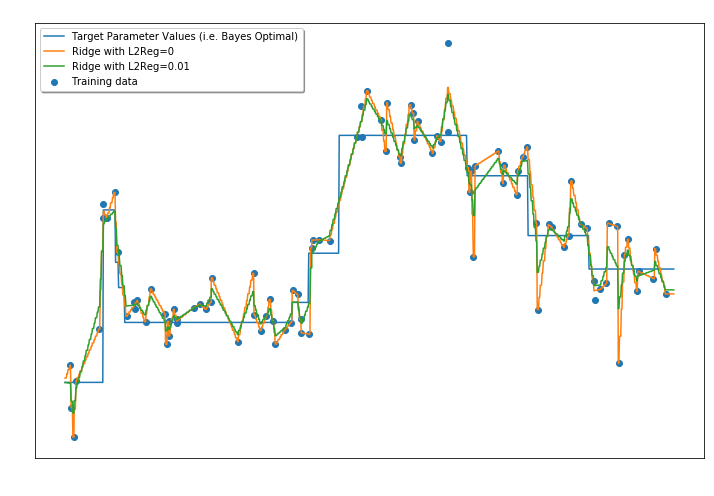

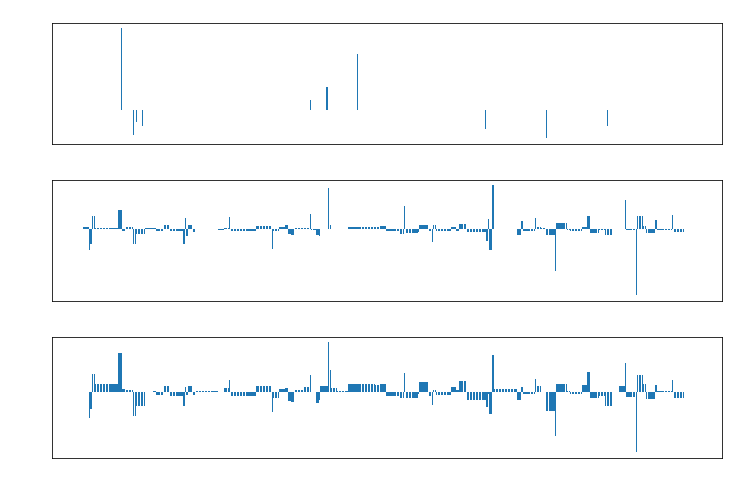

In [8]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
l2regs = [0, grid.best_params_['l2reg']]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()

f = compare_parameter_vectors(pred_fns)
f.show()

# 2.3


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


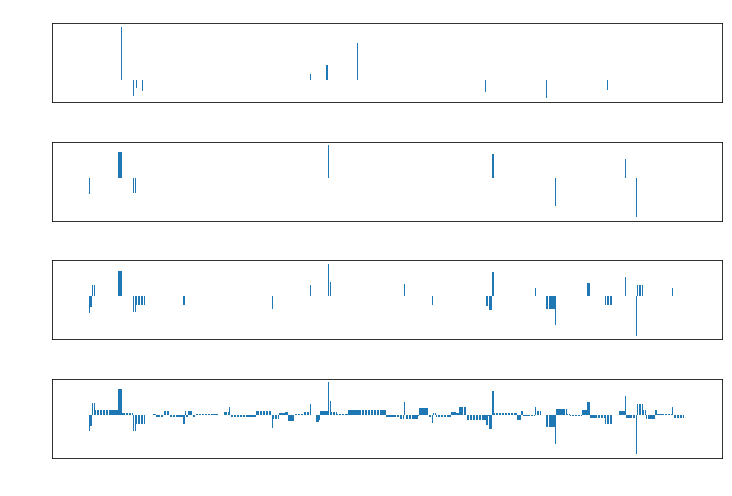

In [9]:
fig, axs = plt.subplots(4,1, sharex=True,figsize = (12,8))
num_ftrs = len(pred_fns[0]["coefs"])
epsilon= [0, 0.2, 0.1, 0.001]
for a in range(1,4):
    coef_vals = [i if abs(i) > epsilon[a] else 0 for i in pred_fns[2]["coefs"]]
    axs[a].bar(range(num_ftrs), coef_vals)
    axs[a].set_title('Ridge with L2Reg = 0.01, epsilon = ' + str(epsilon[a]), color = 'w')
axs[0].bar(range(num_ftrs), pred_fns[0]["coefs"])
for i in range(4):
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Parameter Value')
    axs[i].xaxis.label.set_color('w')
    axs[i].tick_params(axis='x', colors='w')
    axs[i].yaxis.label.set_color('w')
    axs[i].tick_params(axis='y', colors='w')
axs[0].set_title('Target Parameter Values (i.e. Bayes Optimal)', color = 'w')

fig.subplots_adjust(hspace=0.5)
fig.show()

In [10]:
def plot_confusion_matrix(cm, title, classes):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, color = 'w')
    cb = plt.colorbar()
    cb.ax.yaxis.set_tick_params(color='w')
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='w')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color = 'w')
    plt.yticks(tick_marks, classes, color = 'w')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',color = 'w')
    plt.xlabel('Predicted label',color = 'w')

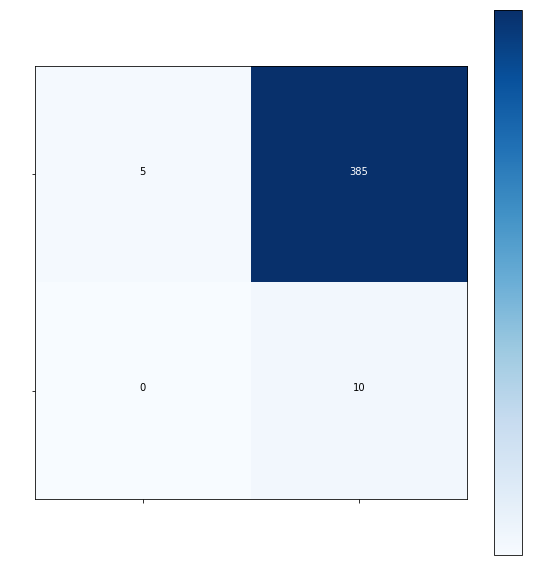

In [11]:
true = [1 if abs(i) > 0 else 0 for i in pred_fns[0]["coefs"]]
coef_vals = [1 if abs(i) > 10e-6 else 0 for i in pred_fns[2]["coefs"]]
cm = confusion_matrix(true, coef_vals)
plot_confusion_matrix(cm, 'Confusion Matrix for epsilon = 10e-6', '01')

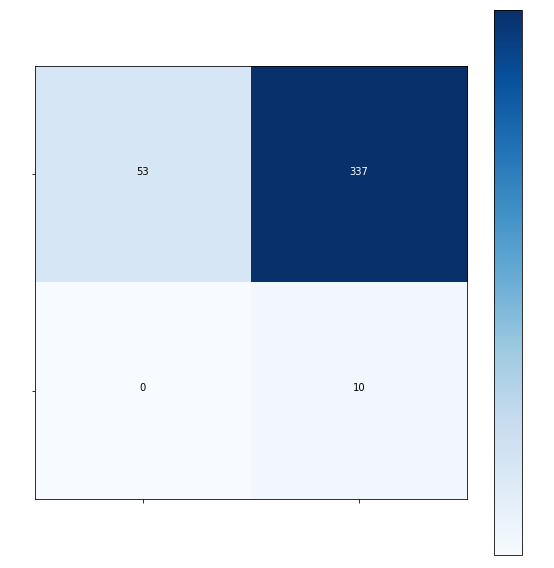

In [12]:
true = [1 if abs(i) > 0 else 0 for i in pred_fns[0]["coefs"]]
coef_vals = [1 if abs(i) > 10e-3 else 0 for i in pred_fns[2]["coefs"]]
cm = confusion_matrix(true, coef_vals)
plot_confusion_matrix(cm, 'Confusion Matrix for epsilon = 10e-3', '01')

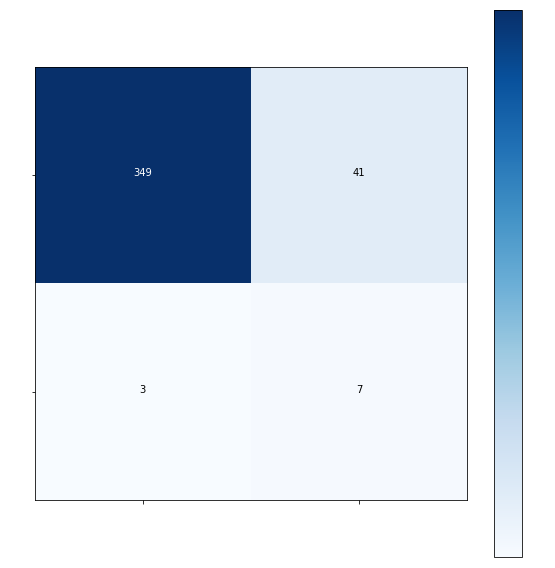

In [13]:
true = [1 if abs(i) > 0 else 0 for i in pred_fns[0]["coefs"]]
coef_vals = [1 if abs(i) > 0.1 else 0 for i in pred_fns[2]["coefs"]]
cm = confusion_matrix(true, coef_vals)
plot_confusion_matrix(cm, 'Confusion Matrix for epsilon = 0.1', '01')

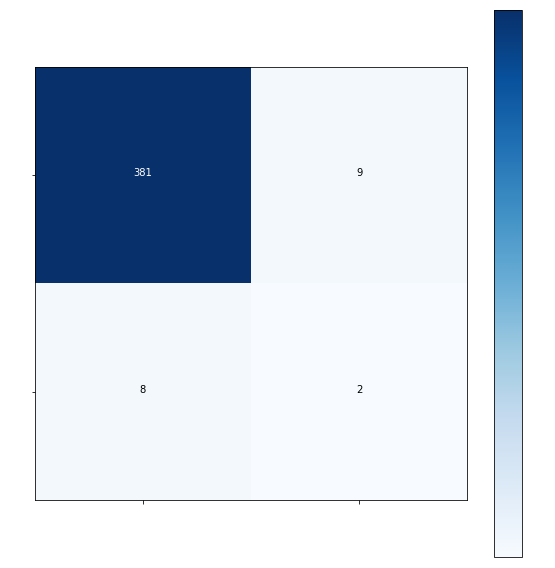

In [14]:
true = [1 if abs(i) > 0 else 0 for i in pred_fns[0]["coefs"]]
coef_vals = [1 if abs(i) > 0.2 else 0 for i in pred_fns[2]["coefs"]]
cm = confusion_matrix(true, coef_vals)
plot_confusion_matrix(cm, 'Confusion Matrix for epsilon = 0.2', '01')

# 3.1.2


In [319]:
def soft(a,b):
    if abs(a) > b:
        return np.sign(a)*(abs(a)-b)
    else:
        return 0

def lasso_obj(X,y,w,lambda_reg,avg = False):
    num_instance = X.shape[0]
    predictions = np.dot(X,w)
    residual = y - predictions
    if avg == True:
        empirical_risk = np.sum(residual**2)/num_instance
    else:
        empirical_risk = np.sum(residual**2)
    l1_norm = np.sum(abs(w))
    objective = empirical_risk + lambda_reg * l1_norm
    return objective

def unison_shuffled_copies(a, b, col = False):
    if col == True:
        p = np.random.permutation(len(a[0]))
        return a.T[p].T, b[p]
    else: 
        p = np.random.permutation(len(a))
        return a[p], b[p]


In [320]:
def coordinate_descent(X, y, lambda_reg, theta = np.zeros(len(X[0])), step_number = 1000, tol = 10e-8, random = False, murphy = False):
    num_features, num_instances = len(X[0]), len(X)
    if murphy == True:
        theta = np.dot(np.dot(np.linalg.inv((np.dot(X.T,X)+lambda_reg*np.identity(X.shape[1]))),X.T),y)
    loss = lasso_obj(X,y,theta,lambda_reg)
    X_,y_ = unison_shuffled_copies(X,y)
    loss_hist = []
    steps = 0
    index = np.array(range(num_features))
    while steps < step_number:
        steps += 1
        if random == True:
            np.random.shuffle(index)
        for j in index:
            colj = X_.T[j]
            aj = 2* sum(colj**2)
            cj = 2*np.dot(colj, y_-np.dot(X_,theta)+theta[j]*colj)
            theta[j] = soft(cj/aj, lambda_reg/aj)
        new_loss = lasso_obj(X_,y_,theta,lambda_reg)
        loss_hist.append(new_loss)
        if abs(new_loss - loss) < tol:
            return theta, loss_hist, steps
        loss = new_loss      
        
    return theta, loss_hist, steps

In [321]:
theta_c, loss_hist_c, pass_c =coordinate_descent(X_train,y_train,0.01)
theta_r, loss_hist_r, pass_r = coordinate_descent(X_train,y_train,0.01,random = True, murphy = True)
theta_m, loss_hist_m, pass_m = coordinate_descent(X_train,y_train,0.01,murphy = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


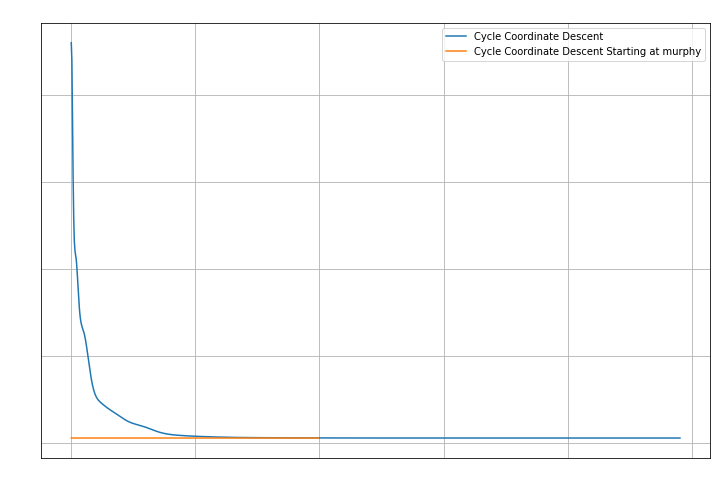

In [322]:
fig, ax = plt.subplots(figsize = (12,8))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.plot(np.array(range(pass_c)),loss_hist_c,label = 'Cycle Coordinate Descent')
# ax.plot(np.array(range(pass_r)),loss_hist_r,label = 'Randomize Coordinate Descent Starting at murphy')
ax.plot(np.array(range(pass_m)),loss_hist_m,label = 'Cycle Coordinate Descent Starting at murphy')
ax.grid()
ax.legend()
ax.set_title("Murphy or not under Cyclic",color = 'w')
ax.set_xlabel("Number of Passes")
ax.set_ylabel("Total Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

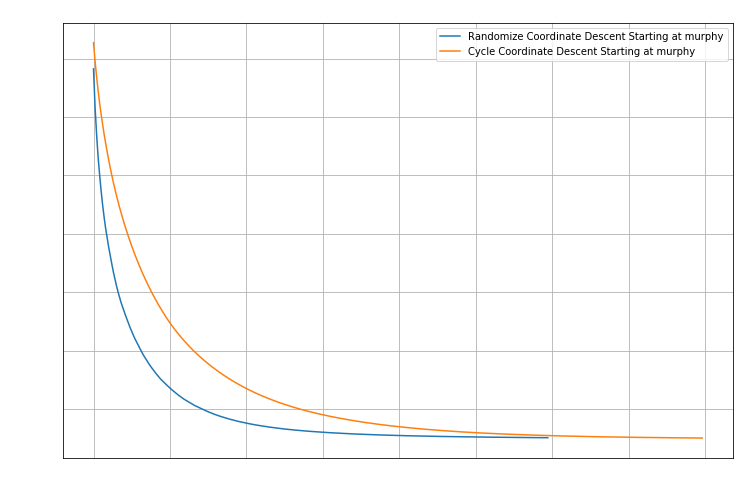

In [323]:
fig, ax = plt.subplots(figsize = (12,8))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
# ax.plot(np.array(range(pass_c)),loss_hist_c,label = 'Cycle Coordinate Descent')
ax.plot(np.array(range(pass_r)),loss_hist_r,label = 'Randomize Coordinate Descent Starting at murphy')
ax.plot(np.array(range(pass_m)),loss_hist_m,label = 'Cycle Coordinate Descent Starting at murphy')
ax.grid()
ax.legend()
ax.set_title("Cycle vs Randomize",color = 'w')
ax.set_xlabel("Number of Passes")
ax.set_ylabel("Total Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

# 3.1.3

In [324]:
lambda_ = np.unique(10.**np.arange(-6,2,1))
loss_ = []
for i in lambda_:
    Theta = coordinate_descent(X_train,y_train,i,random = True, murphy = True)[0]
    loss_.append(lasso_obj(X_val,y_val,Theta,lambda_reg = i))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


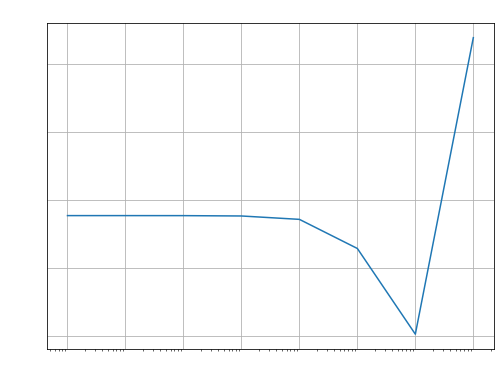

In [325]:
fig, ax = plt.subplots(figsize = (8,6))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(lambda_, loss_)
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization",color = 'w')
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Squared Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

In [345]:
a = {'Lmabda':lambda_,'Loss':loss_}
pd.DataFrame(a)

,Lmabda,Loss
0,0.000001,155.330867
1,0.000010,155.330083
2,0.000100,155.322478
3,0.001000,155.220613
4,0.010000,154.225539
5,0.100000,145.654658
6,1.000000,120.432181
7,10.000000,207.704597


In [212]:
Theta = coordinate_descent(X_train,y_train,1,random = True, murphy = True)[0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


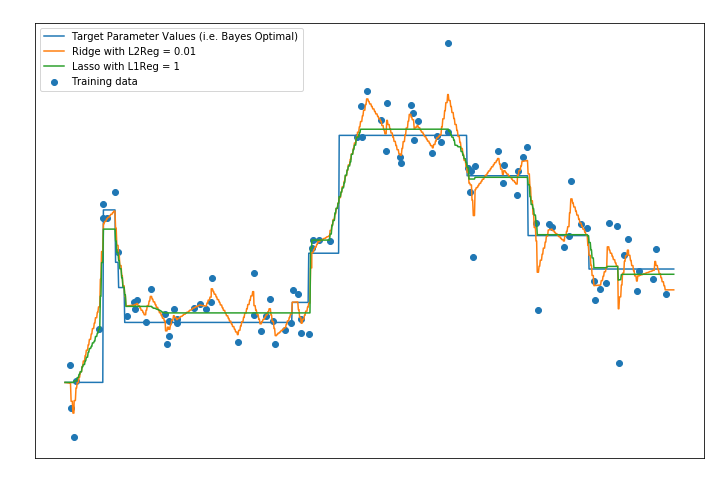

In [224]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
l2regs = [grid.best_params_['l2reg']]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg = "+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
plt.plot(x, np.dot(X, Theta), label = 'Lasso with L1Reg = 1')
plt.legend()


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


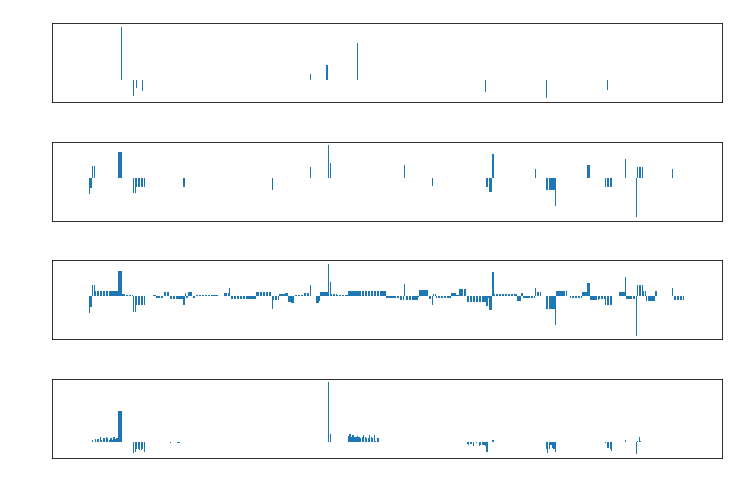

In [236]:
fig, axs = plt.subplots(4,1, sharex=True,figsize = (12,8))
num_ftrs = len(pred_fns[0]["coefs"])
epsilon= [0.1, 0]
for a in [0,1]:
    coef_vals = [i if abs(i) > epsilon[a] else 0 for i in pred_fns[1]["coefs"]]
    axs[a+1].bar(range(num_ftrs), coef_vals)
    axs[a+1].set_title('Ridge with L2Reg = 0.01, epsilon = ' + str(epsilon[a]), color = 'w')
axs[0].bar(range(num_ftrs), pred_fns[0]["coefs"])
axs[3].bar(range(num_ftrs), Theta)
for i in range(4):
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Parameter Value')
    axs[i].xaxis.label.set_color('w')
    axs[i].tick_params(axis='x', colors='w')
    axs[i].yaxis.label.set_color('w')
    axs[i].tick_params(axis='y', colors='w')
axs[0].set_title('Target Parameter Values (i.e. Bayes Optimal)', color = 'w')
axs[3].set_title('Lasso with L1Reg = 1', color = 'w')
fig.subplots_adjust(hspace=0.5)
fig.show()

# 3.1.4

In [285]:
def compute_square_loss(X, y, theta):
    loss = 0 
    m = len(X)
    loss = sum((np.matmul(X,theta) - y)**2)/m
    return loss

In [307]:
lambda_max = 2* max(abs(np.dot(X_train.T, y_train)))
last_theta = np.zeros(len(X[0]))
result = []
for i in range(30):
    last_theta, loss_, pass_ = coordinate_descent(X_train, y_train, lambda_max*(0.8**i)
                                                  , theta = last_theta,random = True)
    result.append(compute_square_loss(X_val,y_val,last_theta))
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


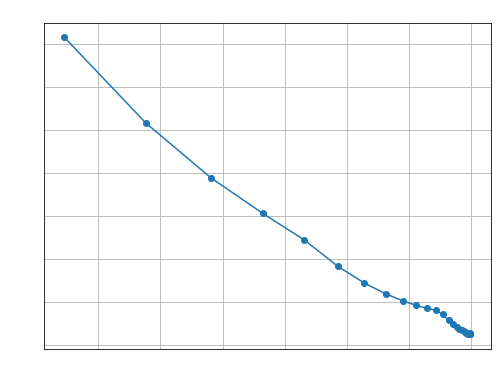

In [308]:
fig, ax = plt.subplots(figsize = (8,6))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.plot([lambda_max*(0.8**i) for i in range(30)], result, '-o')
ax.grid()
ax.set_title("Homotopy Method Result",color = 'w')
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')
plt.gca().invert_xaxis()

In [309]:
min(result)

0.12369819937648675

# 3.1.5

In [310]:
y_train_zero = y_train - np.mean(y_train)
y_val_zero = y_val - np.mean(y_train)

In [311]:
lambda_max = 2* max(abs(np.dot(X_train.T, y_train_zero)))
last_theta = np.zeros(len(X[0]))
result = []
for i in range(30):
    last_theta, loss_, pass_ = coordinate_descent(X_train, y_train_zero, lambda_max*(0.8**i)
                                                  , theta = last_theta,random = True)
    result.append(compute_square_loss(X_val,y_val_zero,last_theta))
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


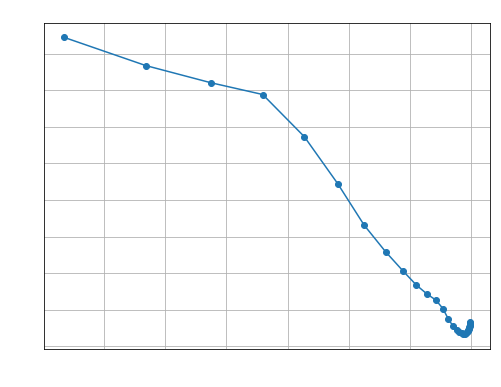

In [316]:
fig, ax = plt.subplots(figsize = (8,6))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.plot([lambda_max*(0.8**i) for i in range(30)], result, '-o')
ax.grid()
ax.set_title("Homotopy Method Result with centered y",color = 'w')
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')
plt.gca().invert_xaxis()

In [313]:
min(result)

0.13389714635283767

In [297]:
grid, results = do_grid_search_ridge(X_train, y_train_zero, X_val, y_val_zero)

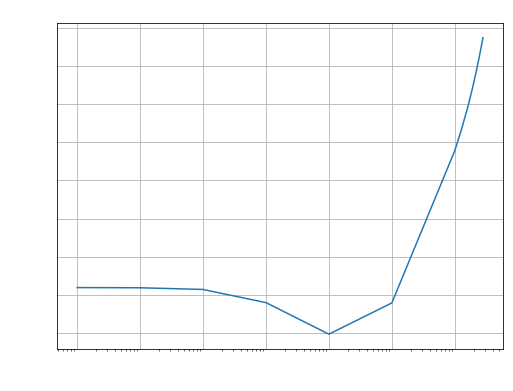

In [306]:
fig, ax = plt.subplots(figsize = (8,6))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization with centered y",color = 'w')
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

In [314]:
lambda_ = np.unique(10.**np.arange(-6,2,1))
loss_ = []
for i in lambda_:
    Theta = coordinate_descent(X_train,y_train_zero,i,random = True, murphy = True)[0]
    loss_.append(lasso_obj(X_val,y_val_zero,Theta,lambda_reg = i))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


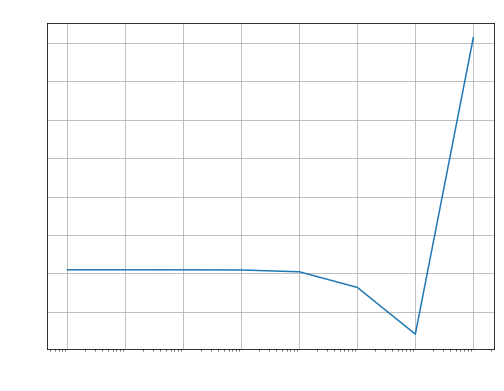

In [317]:
fig, ax = plt.subplots(figsize = (8,6))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(lambda_, loss_)
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization with centered y",color = 'w')
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Squared Error")
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')